# MLP Regressor trained with the California housing dataset

## Setup

In [1]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Import the SSL module and configure certificate verification to be optional to avoid SSLCertVerificationError.
import ssl
ssl.SSLContext.verify_mode = ssl.VerifyMode.CERT_OPTIONAL

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load, split and scale the dataset

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [3]:
# Computing the mean median_house_value.
# We can see that the target value have been scaled down by a factor of 100000
# compared to the Housing dataset used in chapter 2. We should keep this in mind,
# if we want to compare the RMSE of this model with the RMSEs of the other models
# that we trained and tested using the dataset from chapter 2.
housing.target.mean()

2.068558169089147

In [4]:
housing.data.shape

(20640, 8)

## Build, compile, train and evaluate a model

In [5]:
# Build a model.
# We don't need to specify an input layer, since we don't need to convert the input array.
# For regression problems, we don't use an activation function in the output layer.

model = keras.models.Sequential([
    # hidden layer
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    # output layer
    keras.layers.Dense(1)
])

# Compile the model.
# For regression problems, we use the "mean_squared_error" as loss function.
model.compile(loss="mean_squared_error", optimizer="sgd")

In [6]:
# Train the model.
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
134/363 [==========>...................] - ETA: 0s - loss: 1.2067 

2022-11-24 20:26:19.158698: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


363/363 [==============================] - 0s 823us/step - loss: 0.7838 - val_loss: 3.1488
Epoch 2/20
363/363 [==============================] - 0s 434us/step - loss: 0.5304 - val_loss: 5.1705
Epoch 3/20
363/363 [==============================] - 0s 419us/step - loss: 0.5254 - val_loss: 9.4534
Epoch 4/20
363/363 [==============================] - 0s 427us/step - loss: 0.4746 - val_loss: 0.6727
Epoch 5/20
363/363 [==============================] - 0s 434us/step - loss: 0.4186 - val_loss: 0.3869
Epoch 6/20
363/363 [==============================] - 0s 412us/step - loss: 0.4045 - val_loss: 0.3803
Epoch 7/20
363/363 [==============================] - 0s 421us/step - loss: 0.4027 - val_loss: 0.3678
Epoch 8/20
363/363 [==============================] - 0s 420us/step - loss: 0.3938 - val_loss: 0.3735
Epoch 9/20
363/363 [==============================] - 0s 423us/step - loss: 0.3887 - val_loss: 0.3780
Epoch 10/20
363/363 [==============================] - 0s 428us/step - loss: 0.3863 - val_los

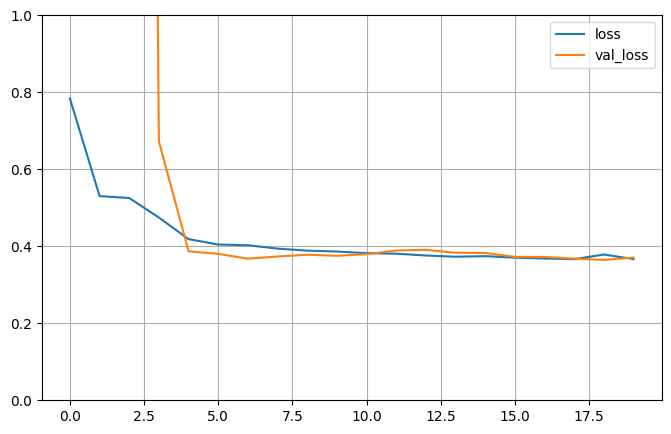

In [7]:
# Show the learning curves.         
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()         

In [8]:
# Evaluate the model (outputs the MSE).
loss = model.evaluate(X_test, y_test)

# Compute and display RMSE
np.sqrt(loss)

162/162 [==============================] - 0s 318us/step - loss: 0.3598


0.5998126005534559

<b>Observation:</b><br/>
If we multipy the RMSE (=loss) with 100000, we can compare with values obtained by the best models that I trained and tested on the dataset used in chapter 2.

Gradient Boosted Forest: 46798 (best model that I trained and tested on the dataset used in chapter 2).

In [9]:
# Make predictions for the first 3 instances in the test set.
X_new = X_test[:3]
y_pred = model.predict(X_new)
y_pred

1/1 [==============================] - 0s 35ms/step


array([[0.70086485],
       [1.7042394 ],
       [4.078005  ]], dtype=float32)

In [10]:
# Compare with the corresponding values target values
y_test[:3]

array([0.477  , 0.458  , 5.00001])

<b>Observation:</b><br/>
The second prediction is very bad given the RMSE. The other two predictions are okay.

## Hyperparameter tuning
We can tune hyperparameters by using Scikit-Learn's <b>GridSearchCV</b> or <b>RandomizedSearchCV</b>. The first will train the network with every combination of the specified hyperparameters, while the latter will randomly pick a number of combinations. For this example, we will use RandomizedSearchCV to avoid getting too many combinations.

We need to wrap the compiled Keras model in an object that mimic a regular Scikit-Learn regressor.

### Create a compiled Keras model and wrap it in a Scikit-Learn KerasRegressor.

In [11]:
# Create a function that will build and compile a Keras model.
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [12]:
# Wrap the Keras model in a Scikit-Learn KerasRegressor.
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/vk/5kv1kws928bgc801_2lf08c40000gn/T/ipykernel_20924/805132444.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


### Use RandomizedSearchCV to tune hyperparameters

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter sets and ranges to explore
param_distribs = {
    "n_hidden": [1, 2, 3, 4],
    "n_neurons": list(range(10, 100)),
    "learning_rate": [5e-4, 5e-3, 5e-2, 5e-1]    #default learning rate is 1e-2
}
                      
# Create an instance of RandomizedSearchCV
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, n_jobs=-1, verbose=2)

# Search
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/hk/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/hk/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/hk/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/hk/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/hk/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprec

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5449 - val_loss: 0.7162
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5533 - val_loss: 4.0439
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6420 - val_loss: 1.6753
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
242/242

242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3166 - val_loss: 0.5307
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3226 - val_loss: 1.1814
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3669 - val_loss: 0.3613
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3165 - val_loss: 0.3908
Epoch 11/100
242/242 [=======

242/242 [==============================] - 0s 1ms/step - loss: 0.2960 - val_loss: 0.3221
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3250 - val_loss: 0.4417
Epoch 18/100
 68/242 [=======>......................] - ETA: 0s - loss: 0.3266[CV] END .......learning_rate=0.05, n_hidden=2, n_neurons=60; total time=   5.5s
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3450 - val_loss: 0.3135
Epoch 6/100
242/242 [==============================] - 0s 974us/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - los

242/242 [==============================] - 0s 2ms/step - loss: 0.3021 - val_loss: 0.2864
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 1.6420 - val_loss: 3.4486
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2922 - val_loss: 0.3327
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0461 - val_loss: 1.7105
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5389 - val_loss: 0.4761
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3399 - val_loss: 0.3574
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5686 - val_loss: 0.5308
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0045 - val_loss: 2.9299
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9905 - val_loss: 2.0342
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2890 - val_loss: 0.3255


242/242 [==============================] - 0s 1ms/step - loss: 0.3823 - val_loss: 0.3651
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4009 - val_loss: 0.3816
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5925 - val_loss: 0.5604
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2779 - val_loss: 0.3093
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0723 - val_loss: 1.1078
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6109 - val_loss: 0.8191
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3857 - val_loss: 1.2227
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2721 - val_loss: 0.2901
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5891 - val_loss: 0.5449
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3030 - val_loss: 0

242/242 [==============================] - 0s 1ms/step - loss: 0.5087 - val_loss: 0.4909
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4975 - val_loss: 0.4618
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5116 - val_loss: 0.4832
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3535 - val_loss: 0.4131
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2622 - val_loss: 0.5169
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2742 - val_loss: 0.2819
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5001 - val_loss: 0.4901
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 4/100
2

242/242 [==============================] - 0s 1ms/step - loss: 0.4372 - val_loss: 0.4301
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2460 - val_loss: 0.2742
Epoch 39/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3338 - val_loss: 0.3438
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5943 - val_loss: 0.5601
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6868 - val_loss: 1.7571
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3319 - val_loss: 0.3299
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6683 - val_loss: 0.7297
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4200 - val_loss: 0.4128
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4263 - val_loss: 0.3986
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4347 - val_loss: 0.4

242/242 [==============================] - 0s 1ms/step - loss: 0.5311 - val_loss: 0.5044
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3244 - val_loss: 0.3204
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4172 - val_loss: 0.4254
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4611 - val_loss: 0.4330
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5051 - val_loss: 0.4663
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4076 - val_loss: 0.3879
Epoch 46/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3991 - val_loss: 0.3875
Epoch 44/100
Epoch 47/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5172 - val_loss: 0.4968
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3237 - val_loss: 0.3803
Epoch 46/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4156

242/242 [==============================] - 0s 813us/step - loss: 0.4030 - val_loss: 0.4251
Epoch 55/100
242/242 [==============================] - 0s 828us/step - loss: 0.3161 - val_loss: 0.3054
Epoch 55/100
242/242 [==============================] - 0s 945us/step - loss: 0.4002 - val_loss: 0.3832
Epoch 26/100
242/242 [==============================] - 0s 857us/step - loss: 0.3138 - val_loss: 0.3128
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4358 - val_loss: 0.4381
Epoch 25/100
242/242 [==============================] - 0s 967us/step - loss: 0.4382 - val_loss: 0.4110
Epoch 26/100
242/242 [==============================] - 0s 876us/step - loss: 0.4019 - val_loss: 0.4241
Epoch 56/100
242/242 [==============================] - 0s 873us/step - loss: 0.3923 - val_loss: 0.3821
Epoch 57/100
242/242 [==============================] - 0s 925us/step - loss: 0.3161 - val_loss: 0.3031
Epoch 56/100
242/242 [==============================] - 0s 985us/step - loss: 0

242/242 [==============================] - 0s 796us/step - loss: 0.3090 - val_loss: 0.3261
Epoch 67/100
242/242 [==============================] - 0s 850us/step - loss: 0.3699 - val_loss: 0.3860
Epoch 37/100
242/242 [==============================] - 0s 809us/step - loss: 0.3804 - val_loss: 0.3802
Epoch 69/100
242/242 [==============================] - 0s 902us/step - loss: 0.3913 - val_loss: 0.3818
Epoch 36/100
242/242 [==============================] - 0s 908us/step - loss: 0.3991 - val_loss: 0.3874
Epoch 37/100
242/242 [==============================] - 0s 799us/step - loss: 0.3090 - val_loss: 0.2966
Epoch 68/100
242/242 [==============================] - 0s 947us/step - loss: 0.3905 - val_loss: 0.4201
Epoch 68/100
242/242 [==============================] - 0s 824us/step - loss: 0.3684 - val_loss: 0.3915
Epoch 38/100
242/242 [==============================] - 0s 786us/step - loss: 0.3794 - val_loss: 0.3672
Epoch 70/100
242/242 [==============================] - 0s 877us/step - loss:

242/242 [==============================] - 0s 642us/step - loss: 0.3692 - val_loss: 0.3748
Epoch 85/100
242/242 [==============================] - 0s 741us/step - loss: 0.3712 - val_loss: 0.3720
Epoch 51/100
242/242 [==============================] - 0s 623us/step - loss: 0.3004 - val_loss: 0.4683
Epoch 84/100
242/242 [==============================] - 0s 627us/step - loss: 0.3798 - val_loss: 0.4132
Epoch 84/100
242/242 [==============================] - 0s 613us/step - loss: 0.3686 - val_loss: 0.3633
Epoch 86/100
242/242 [==============================] - 0s 727us/step - loss: 0.3696 - val_loss: 0.3799
Epoch 52/100
242/242 [==============================] - 0s 625us/step - loss: 0.3791 - val_loss: 0.4052
Epoch 85/100
242/242 [==============================] - 0s 620us/step - loss: 0.3680 - val_loss: 0.3676
Epoch 87/100
242/242 [==============================] - 0s 584us/step - loss: 0.3787 - val_loss: 0.4114
Epoch 86/100
242/242 [==============================] - 0s 683us/step - loss:

/Users/hk/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [        nan -0.35615668         nan         nan         nan -0.30967164
 -0.38306371 -0.35094832         nan -0.36732407]
  warnings.warn(
/Users/hk/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


363/363 [==============================] - 0s 690us/step - loss: 0.5500 - val_loss: 0.4232
Epoch 2/100
363/363 [==============================] - 0s 496us/step - loss: 0.3853 - val_loss: 0.8073
Epoch 3/100
363/363 [==============================] - 0s 513us/step - loss: 0.3700 - val_loss: 0.3326
Epoch 4/100
363/363 [==============================] - 0s 493us/step - loss: 0.3459 - val_loss: 0.3433
Epoch 5/100
363/363 [==============================] - 0s 490us/step - loss: 0.3341 - val_loss: 0.3431
Epoch 6/100
363/363 [==============================] - 0s 558us/step - loss: 0.3252 - val_loss: 0.5594
Epoch 7/100
363/363 [==============================] - 0s 514us/step - loss: 0.3214 - val_loss: 0.4342
Epoch 8/100
363/363 [==============================] - 0s 515us/step - loss: 0.3098 - val_loss: 1.8370
Epoch 9/100
363/363 [==============================] - 0s 502us/step - loss: 0.3004 - val_loss: 0.3659
Epoch 10/100
363/363 [==============================] - 0s 523us/step - loss: 0.2956 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x1079e0430>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0005, 0.005, 0.05,
                                                          0.5],
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, 32, 33,
                                                      34, 35, 36, 37, 38, 39, ...]},
                   verbose=2)

In [14]:
# Display the parameters of the best model.
rnd_search_cv.best_params_

{'n_neurons': 64, 'n_hidden': 4, 'learning_rate': 0.05}

In [15]:
# Get the model for the best estimator, and evaluate it on the test set (outputs the MSE).

best_model = rnd_search_cv.best_estimator_.model
loss = best_model.evaluate(X_test, y_test)

# Compute and display RMSE
np.sqrt(loss)

162/162 [==============================] - 0s 378us/step - loss: 0.2692


0.5188452414900341

### Note
There are many alternative techniques that can explore a search space more efficient than RandomSerarchCV. There are a list of libraries in the book on pages 322-333.

I have tried BayesSearchCV, but results have been dissapointing so far.

## TensorFlow Serving

You can deploy a model as a REST API using TensorFlow Serving (TF Serving).

In [16]:
# Before you start TF Serving, you should export the model to TensorFlow's SavedModel format.
model_version = "03"
model_name = "housing_model"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: housing_model/03/assets


In this example, I will install TF Serving using a Docker image (there are also other options).

First, you should pull the Docker image by typing the following command from the command prompt:

docker pull tensorflow/serving

Then you can run the docker image by typing a command similar to the following:

docker run -it --rm -p 8500:8500 -p 8501:8501 -v "/Users/hk/Documents/Undervisning/ML/Examples/housing_model:/models/housing_model" -e MODEL_NAME=housing_model tensorflow/serving

In [17]:
# You can make a prediction by querying TF Serving REST API. A query must be a POST request,
# and the input data must be passed in the request body as a JSON object.

# (I will make the request in Postman)

import json

input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist()
})

input_data_json

'{"signature_name": "serving_default", "instances": [[-1.157801044672084, -0.28673138272452353, -0.49550876553420803, -0.16618096584447373, -0.029460121855354803, 0.38899735425767396, 0.19374820779179167, 0.28704739633254056], [-0.71255310326722, 0.10880952094123046, -0.16332972890163902, 0.20164651866470046, 0.12842116621683547, -0.11818173761799093, -0.237252610085982, 0.062152314019760624], [-0.21561010032058425, 1.849189497070548, -0.5798278760656232, 0.18528489288618866, -0.10429402718436985, -0.6769490515190195, 1.0089019285606207, -1.4271528977404662]]}'